# Preamable

> Download and extract data for notebook execution.

The cell below prepares the Google Colab environment for execution. It will download our dataset and the FLIM-Weights, which we will use in this notebook.

It will also install the pyift library, which we will use to develop our FLIM-Network.

In [1]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import sys

def download_and_extract_zip(url, extract_path):
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(extract_path)

if not os.path.exists("./parasites"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1Uwi8LYXYNnCp2brnuD49JrrWTrv_2HII&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Data already downloaded")

if not os.path.exists("./pyift_whl"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1ddlcSqwli4UIFlJvqhVLUc8kduFlsXDj&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Pyift folder already downloaded")

python_version = sys.version_info
sub_version = python_version.minor

# Install the whl located on data
whl_path = f"pyift_whl/3_{sub_version}/pyift-0.1-cp3{sub_version}-cp3{sub_version}-linux_x86_64.whl"
!python -m pip install $whl_path

# Get path to site-packages
import site
site_packages_path = site.getsitepackages()[0]
# Get absolute path
abs_path = os.path.realpath(f"pyift_whl/3_{sub_version}/pyift")

# Create Symbolick Link
!ln -s $abs_path/_pyift.*.so $site_packages_path/pyift/

[INFO] Data already downloaded
[INFO] Pyift folder already downloaded
Processing ./pyift_whl/3_10/pyift-0.1-cp310-cp310-linux_x86_64.whl
pyift is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
ln: failed to create symbolic link '/usr/local/lib/python3.10/dist-packages/pyift/_pyift.cpython-310-x86_64-linux-gnu.so': File exists


# Developing a FLIM-Network, free of backpropagation

> This notebook covers the steps to define and use a FLIM network. A FLIM network comprises two components: A FLIM-Encoder, which extracts features from an input image, and an Adaptive Decoder, which decodes the extracted features into a saliency map. Additionally, in this notebook, we will also show how to post-process the saliency map, using a [Dynamic Tree](https://link.springer.com/chapter/10.1007/978-3-030-13469-3_55) algorithm, to improve the saliency map.

This notebook covers the following:

1. Preparing the environment. Here, we will implement the datasets and the data loaders, and also the FLIM-Encoder and the methods to load the weights;
2. Explore FLIM-Network. Here, we will learn how to extract features, decode them, and post-process them.
3. Assess our FLIM network. Finally, we will assess our model on training and test data.

## 1. Preparing the environment

We start importing the necessary libraries:

In [63]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
from tqdm import tqdm
from typing import List, Union
import json

from PIL import ImageOps
from tifffile import imsave
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

from skimage.color import lab2rgb
import cv2

We define some of our variables:

In [3]:
DATA_PATH = Path("parasites/data/")
ORIG_PATH = DATA_PATH / Path("orig")
LABELS_PATH = DATA_PATH / Path("label")
DEVICE = "cuda"

# Run FLIM Model
FLIM_PATH = Path("parasites/flim_data")
ARCH_JSON = Path(
    FLIM_PATH / Path("arch_sample.json")
)
WEIGHTS_PATH = Path(
    FLIM_PATH / Path("bofp_model")
)

# Reads architecture dict to define our network
with open(ARCH_JSON, "r") as json_data:
    arch_description = json.load(json_data)

We split our data into train and test:

In [4]:
images = os.listdir(ORIG_PATH)
images.sort()
labels = images
print(f"N images {len(images)}")

# 70% of train and 30% of test
n_train = int((0.7 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]
# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

print(f"{len(train_images)} training images")
print(f"{len(test_images)} testing images")

N images 100
70 training images
30 testing images


We implement and define our datasets and dataloaders:

In [5]:
import pyift.pyift as ift

In [6]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32)
        ])

    def __len__(self):
        # If image id not provided, we are training with the whole dataset
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def load_image(self, path):
        image = ift.ReadImageByExt(path)
        mimage = ift.ImageToMImage(image, color_space=ift.LABNorm2_CSPACE)
        image = mimage.AsNumPy()
        image = image.squeeze()

        return image

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = self.load_image(str(image_path))
        image = self.transforms(image)

        label = ImageOps.grayscale(Image.open(label_path))
        label = self.transforms(label)

        return image, label

In [7]:
# DATASETS - TRAIN AND TEST
train_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=train_images,
    labels=train_labels,
    image_id=None
)
test_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=test_images,
    labels=test_labels,
    image_id=None
)

In [8]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
test_dataloader  = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([1, 3, 400, 400])
Labels shape =>  torch.Size([1, 1, 400, 400])


Finally, we implement our FLIM Encoder, define it, and load FLIM-Encoder Weights.

In [9]:
# Upsamples input feature map
def get_up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )

# Defines convolutional blocks for our decoder
def get_conv_block(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.ReLU(inplace=True),
    )

# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [10]:
class FLIMEncoder(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
    ) -> None:
        super().__init__()

        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Encoder Convolutional Blocks
        self.block1 = get_conv_block(
            in_channels=in_channels,
            out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],
            padding=kernel_sizes[0] // 2
        )
        self.block2 = get_conv_block(
            in_channels=n_kernels[0],
            out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],
            padding=kernel_sizes[1] // 2
        )
        self.block3 = get_conv_block(
            in_channels=n_kernels[1],
            out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],
            padding=kernel_sizes[2] // 2
        )
        self.max_pool = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": []}

        # Encoder
        x = self.max_pool(self.block1(x))
        self.activations["encoder"].append(x)
        x = self.max_pool(self.block2(x))
        self.activations["encoder"].append(x)
        x = self.max_pool(self.block3(x))
        self.activations["encoder"].append(x)

        return x

def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")

    bias = np.array(bias).astype(np.float32)

    return bias


def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:

    nkernels = weights.shape[1]

    shifted_weights = np.zeros((nkernels,in_channels,kernel_size[1],kernel_size[0]))

    for k in range(nkernels):
        for channel in range(in_channels):
            i = channel
            for row in range(kernel_size[1]):
                for col in range(kernel_size[0]):
                    shifted_weights[k][channel][row][col] = weights[i][k]
                    i = i + in_channels

    return shifted_weights


def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)

    return weights

def load_FLIM_encoder(model: FLIMEncoder, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)

    n_layers = arch_description["nlayers"]

    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"block{n}")

        # Sets its biases
        bias_path = weights_path / Path(f"conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias.to(DEVICE)

        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights.to(DEVICE)

        in_channels = channels[n]

In [11]:
# If necessary install torchview
!python -m pip install torchview

In [12]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [13]:
flim_encoder = FLIMEncoder(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0],
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ]
).to(DEVICE)

load_FLIM_encoder(
    model=flim_encoder,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


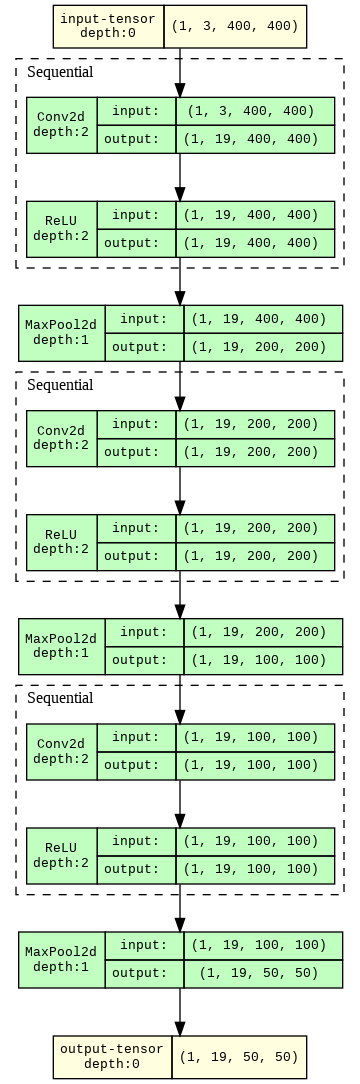

In [14]:
model_graph = draw_graph(
    flim_encoder, input_size=(1,3,400,400), expand_nested=True
)
model_graph.visual_graph

## 2. Explore FLIM-Network.

Let us start by implementing a method that runs our whole pipeline:

1. Extract features using a FLIM-Encoder;
2. Decode features using AdaptiveDecoders into a saliency map;
 1. ift.SimpleAdaptiveDecoder;
 2. ift.ProbabilityBasedAdaptiveDecoder;
 3. ift.MeanBasedAdaptiveDecoder.
3. Post-process the saliency map dynamic-tree.

For further details about AdaptiveDecoders, see our laboratory's theoretical materials and a recent [paper](https://ieeexplore.ieee.org/document/10716333) "Adaptive Decoders for FLIM-Based Salient Object Detection Networks".

In [99]:
def get_rgb_img(input_image):
  img = input_image.permute(1, 2, 0).detach().cpu().numpy().copy()
  img[:,:, 0] = img[:,:, 0] * 99.998337
  img[:,:, 1] = img[:,:, 1] * (86.182236 + 98.258614) - 86.182236
  img[:,:, 2] = img[:,:, 2] * (107.867744 + 94.481682) - 107.867744
  img = lab2rgb(img)

  return img

def run_FLIM_pipeline(flim_encoder, input_image, visualize=False):
  rgb_img = get_rgb_img(input_image)
  flim_encoder(input_image.unsqueeze(0).to(DEVICE))

  img = ift.CreateMImageFromNumPy(
       np.ascontiguousarray(input_image.permute(1,2,0).detach().cpu().numpy()).astype(np.float32)
  )
  saliencies = []
  processed_saliencies = []
  for idx, features in enumerate(flim_encoder.activations["encoder"]):
    mimg = ift.CreateMImageFromNumPy(
      np.ascontiguousarray(features.squeeze(0).permute(1,2,0).detach().cpu().numpy()).astype(np.float32)
    )
    saliency = ift.MeanBasedAdaptiveDecoder(
      mimg,
      str(WEIGHTS_PATH), # Path to FLIM Model
      "",
      idx + 1
    )

    sy = img.AsNumPy().shape[1]  / saliency.AsNumPy().shape[1]
    sx = img.AsNumPy().shape[2]  / saliency.AsNumPy().shape[2]
    saliency_i = ift.Interp2D(ift.MImageToImage(saliency, 255, 1), sy, sx)

    orig_image = ift.ReadImageByExt(
      "parasites/data/orig/000001.png"
    )
    processed_saliency = ift.SMansoniDelineation(
      img,
      saliency_i, # saliency image (label 1)
      1, # border_dist,
      1000, # min_obj_area,
      9000, # max_obj_area,
      1, # seed_erosion,
      7 # seed_dilation
    )
    processed_saliencies.append(processed_saliency.AsNumPy())
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

        axes[0].imshow(rgb_img)
        axes[0].set_title(f"Original Image (Layer {idx + 1})")

        axes[1].imshow(saliency.AsNumPy()[0,...,1], cmap="gray")
        axes[1].set_title(f"Saliency Map (Layer {idx + 1})")

        axes[2].imshow(processed_saliencies[-1], cmap="gray")
        axes[2].set_title(f"Processed Saliency Map (Layer {idx + 1})")

        plt.show() # Show the plot for each iteration

  return processed_saliencies

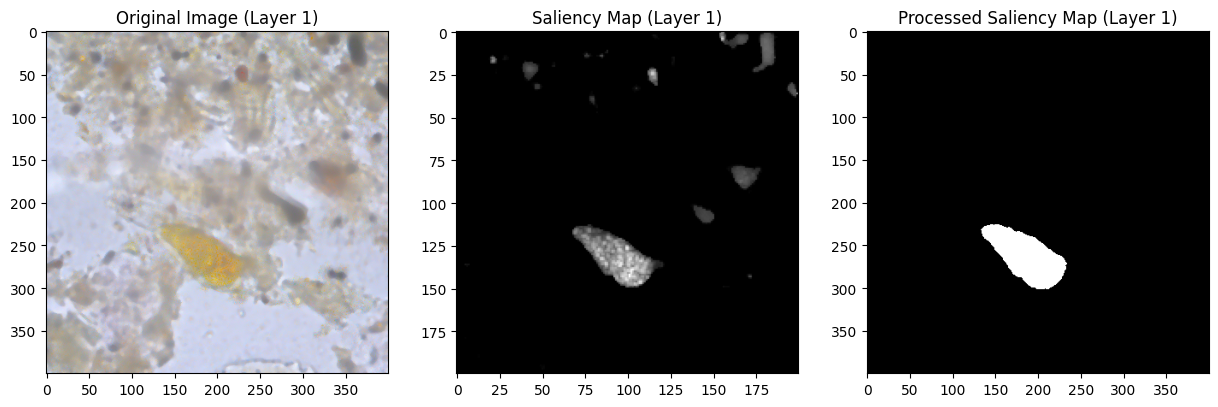

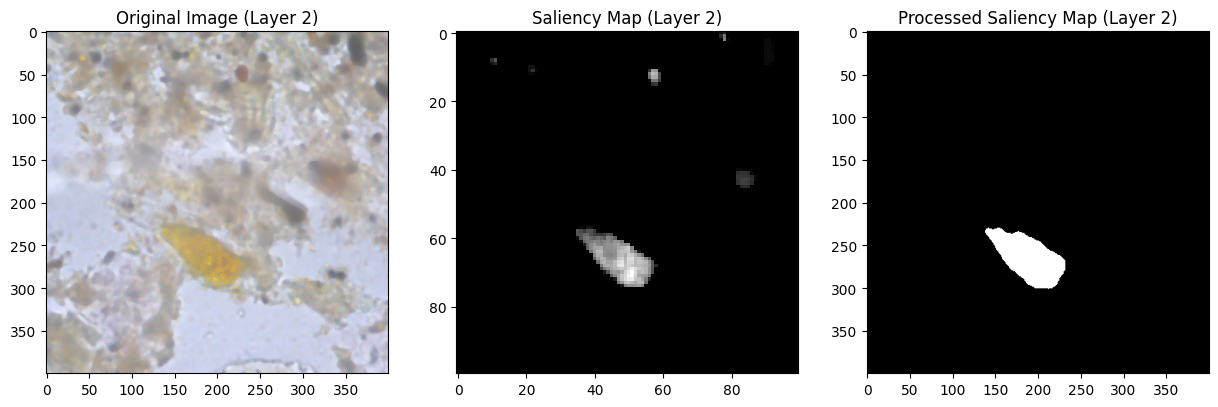

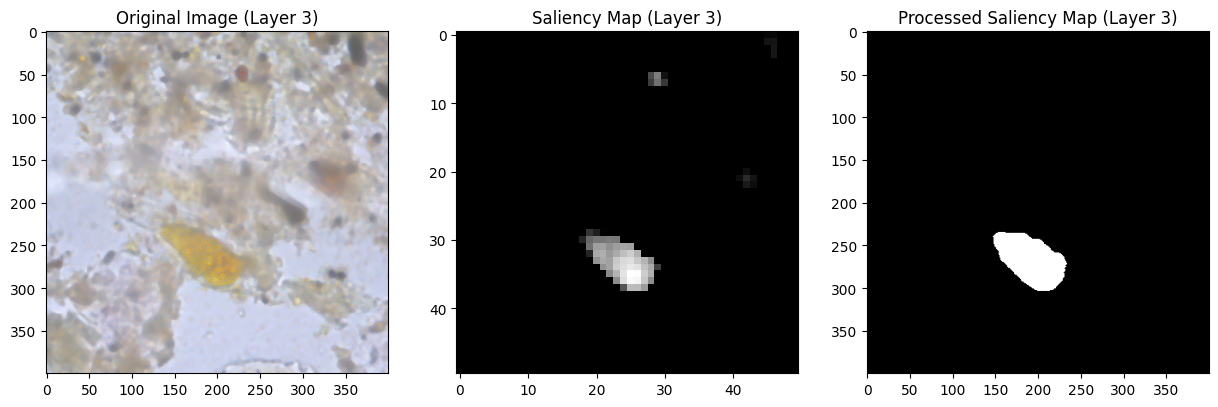

In [100]:
sample_image, sample_label = train_dataset.__getitem__(3)
saliencies = run_FLIM_pipeline(flim_encoder, sample_image, True)

> Explore other images, and also other AdaptiveDecoders to see what happens.

## 3. Assess our FLIM network.

Our pipeline is working end to end. To finish our experiments, we will assess our pipeline for each layer on training and testing data.

First, we import the necessary libraries

In [101]:
# If necessary install medpy and torchmetrics
!python -m pip install medpy
!python -m pip install torchmetrics

In [102]:
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

In [103]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: FLIMEncoder,
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = "preds/"
    os.makedirs(folder_to_save, exist_ok=True)

    accuracies = {"layer1": [], "layer2": [], "layer3": []}
    dices =  {"layer1": [], "layer2": [], "layer3": []}
    ious =  {"layer1": [], "layer2": [], "layer3": []}
    jaccard_index = JaccardIndex(num_classes=2, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image = data_loader.dataset.load_image(str(image_path))
        image_data = data_loader.dataset.transforms(image)
        ground_truth = data_loader.dataset.transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension

        predictions = run_FLIM_pipeline(model, image_data)

        for idx, mask in enumerate(predictions):
          image_name = os.path.basename(image_path)
          image_name = image_name.split(".")[0] + f"_layer{idx + 1}" + ".png"
          path_to_save = folder_to_save / Path(image_name)

          accuracy = np.mean((mask == ground_truth).astype(np.float32))
          accuracies[f"layer{idx+1}"].append(accuracy)
          # Verifies if there is parasite eggs on images
          if np.any(ground_truth > 0):
              dice = binary.dc(mask, ground_truth)
              dices[f"layer{idx+1}"].append(dice)
              iou = jaccard_index(torch.Tensor(mask).long(), torch.Tensor(ground_truth).long())
              ious[f"layer{idx+1}"].append((iou.numpy()))
          else: # If not
              # If there is no parasite and our model predicted it, dice and iou equals 0
              if np.any(mask > 0):
                  dices[f"layer{idx+1}"].append(0)
                  ious[f"layer{idx+1}"].append(0)
              # If there is no parasite and our model do not predicted it, dice and iou equals 1 (100%)
              else:
                  dices[f"layer{idx+1}"].append(1)
                  ious[f"layer{idx+1}"].append(1)


          cv2.imwrite(
              str(path_to_save), mask * 255
          )

    for layer in ["layer1", "layer2", "layer3"]:
        print(f"[INFO] Metrics for {layer}")
        print(f"[INFO] Avg Accuracy: {np.mean(np.array(accuracies[layer]))} +/- {np.std(np.array(accuracies[layer]))}")
        print(f"[INFO] Avg Dice: {np.mean(np.array(dices[layer]))} +/- {np.mean(np.array(dices[layer]))}")
        print(f"[INFO] Avg IoU: {np.mean(np.array(ious[layer]))} +/- {np.mean(np.array(ious[layer]))}")

In [104]:
predict_and_evaluate(model=flim_encoder, data_loader=train_dataloader)

70it [00:40,  1.72it/s]

[INFO] Metrics for layer1
[INFO] Avg Accuracy: 0.9789921641349792 +/- 0.018233681097626686
[INFO] Avg Dice: 0.6799388255404308 +/- 0.6799388255404308
[INFO] Avg IoU: 0.5555036664009094 +/- 0.5555036664009094
[INFO] Metrics for layer2
[INFO] Avg Accuracy: 0.9878447651863098 +/- 0.010489225387573242
[INFO] Avg Dice: 0.7528408798360632 +/- 0.7528408798360632
[INFO] Avg IoU: 0.6334642767906189 +/- 0.6334642767906189
[INFO] Metrics for layer3
[INFO] Avg Accuracy: 0.9885578751564026 +/- 0.00984255876392126
[INFO] Avg Dice: 0.7552135902219823 +/- 0.7552135902219823
[INFO] Avg IoU: 0.6396239399909973 +/- 0.6396239399909973


In [105]:
predict_and_evaluate(model=flim_encoder, data_loader=test_dataloader)

30it [00:21,  1.42it/s]

[INFO] Metrics for layer1
[INFO] Avg Accuracy: 0.9746245741844177 +/- 0.027118830010294914
[INFO] Avg Dice: 0.7094156978885108 +/- 0.7094156978885108
[INFO] Avg IoU: 0.5751997232437134 +/- 0.5751997232437134
[INFO] Metrics for layer2
[INFO] Avg Accuracy: 0.9907228946685791 +/- 0.008207449689507484
[INFO] Avg Dice: 0.8406576327978867 +/- 0.8406576327978867
[INFO] Avg IoU: 0.7377515435218811 +/- 0.7377515435218811
[INFO] Metrics for layer3
[INFO] Avg Accuracy: 0.9912331700325012 +/- 0.007703402545303106
[INFO] Avg Dice: 0.8444286780761647 +/- 0.8444286780761647
[INFO] Avg IoU: 0.7424687147140503 +/- 0.7424687147140503


As we can see, with only two layers, our average Dice on the test set is close to the models trained with backpropagation. This possibility depicts the potential of FLIM and opens space for further investigations.

Thank you. We hope you had a great experience learning about FLIM.